# О проекте
<a id='target100'></a>

Есть данные сервиса по продаже билетов на развлекательные мероприятия: логи пользовательской активности на сайте, выгрузка заказов и выгрузка рекламных расходов. Данные с июня 2017 по конец мая 2018, выручка в условных единицах. Цель - помочь отделу маркетинга перераспределить бюджет на следующий год.

### План:

1. [Знакомство с данными](#target1) 
2. [Источники трафика](#target2) 
3. [Маркетинговые затраты](#target3) 
4. [Изменение метрик роста из месяца в месяц](#target4)
5. [Длительность сессии, desktop и touch устройства](#target5)
6. [Конверсия во вторую покупку](#target6)
7. [Когорты](#target7)
8. [Резюме](#target99)

<a id='target1'></a>
## Знакомство с данными 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['lines.dashed_pattern'] = [3, 1.6]
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import display
from my_module import *

In [2]:
visits = downcast_convertion(pd.read_csv('datasets/visits_log.csv', 
                                         names = ['device', 'close', 'source_id', 'open', 'uid'], header = 0))
orders = downcast_convertion(pd.read_csv('datasets/orders_log.csv', 
                                         names = ['time_of_purchase', 'revenue', 'uid'], header = 0))
costs = downcast_convertion(pd.read_csv('datasets/costs.csv'))

orders = orders[['time_of_purchase', 'uid', 'revenue']]
visits = visits[['open', 'close', 'uid', 'source_id', 'device']]

visits['open'] = pd.to_datetime(visits['open'], infer_datetime_format = True)
visits['close'] = pd.to_datetime(visits['close'], infer_datetime_format = True)
orders['time_of_purchase'] = pd.to_datetime(orders['time_of_purchase'], infer_datetime_format = True)
costs['dt'] = pd.to_datetime(costs['dt'], infer_datetime_format = True)

for df in [visits, orders, costs]:
    display(df.head())
    display(df.info())
    if df.duplicated().sum() != 0:
        print('Есть дублированные записи')
    print('')

,open,close,uid,source_id,device
0,2017-12-20 17:20:00,2017-12-20 17:38:00,16879256277535980062,4,touch
1,2018-02-19 16:53:00,2018-02-19 17:21:00,104060357244891740,2,desktop
2,2017-07-01 01:54:00,2017-07-01 01:54:00,7459035603376831527,5,touch
3,2018-05-20 10:59:00,2018-05-20 11:23:00,16174680259334210214,9,desktop
4,2017-12-27 14:06:00,2017-12-27 14:06:00,9969694820036681168,3,desktop


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   open       359400 non-null  datetime64[ns]
 1   close      359400 non-null  datetime64[ns]
 2   uid        359400 non-null  uint64        
 3   source_id  359400 non-null  uint8         
 4   device     359400 non-null  category      
dtypes: category(1), datetime64[ns](2), uint64(1), uint8(1)
memory usage: 8.9 MB


None

,time_of_purchase,uid,revenue
0,2017-06-01 00:10:00,10329302124590727494,17.00
1,2017-06-01 00:25:00,11627257723692907447,0.55
2,2017-06-01 00:27:00,17903680561304213844,0.37
3,2017-06-01 00:29:00,16109239769442553005,0.55
4,2017-06-01 07:58:00,14200605875248379450,0.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time_of_purchase  50415 non-null  datetime64[ns]
 1   uid               50415 non-null  uint64        
 2   revenue           50415 non-null  float32       
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.7 KB


None

,source_id,dt,costs
0,1,2017-06-01,75.199997
1,1,2017-06-02,62.250000
2,1,2017-06-03,36.529999
3,1,2017-06-04,55.000000
4,1,2017-06-05,57.080002


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   uint8         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float32       
dtypes: datetime64[ns](1), float32(1), uint8(1)
memory usage: 32.3 KB


None

Дублей, пропусков нет. Типы данных, названия столбцов удобны для работы. Значение 'revenue', судя по всему, описывает не всю сумму транзакции (пользователи покупают билеты), а выручку компании после вычета закупочной цены, так как сказали исходить из маржинальности 100%. Проверим, нет ли наблюдений, в которых дублируется не вся строка, но 'uid' вместе с временем начала сессии.

In [3]:
visits[ visits.duplicated(subset = ['uid', 'open'], keep = False) ]

,open,close,uid,source_id,device
44993,2018-03-16 08:55:00,2018-03-16 08:57:00,1981020429381477763,1,touch
47067,2018-03-16 08:55:00,2018-03-16 08:55:00,1981020429381477763,1,touch


Такие наблюдения нашлись, но, к счастью, их немного. Баг репорт, и их следует удалить.

In [4]:
visits = visits.drop(index = [44993, 47067]).reset_index(drop = True)

Ещё несколько проверок на корректность. Значение в 'close' должно быть всегда больше 'open', а разница между ними не больше 12 часов. Выведем строки, для которых это не так.

In [5]:
visits[ (visits.close < visits.open) | (visits.close - visits.open > '12 hours') ]

,open,close,uid,source_id,device
4181,2018-03-25 03:50:00,2018-03-25 03:18:00,13092152539246794986,3,desktop
177970,2018-03-25 03:55:00,2018-03-25 03:09:00,4621202742905035453,9,desktop


Похоже на небольшой сбой, произошедший ночью 25го марта. Баг репорт, и две ошибочные строки можно удалить. 

In [6]:
visits = visits.drop(index = [4181, 177970]).reset_index(drop = True)

Проверим источники трафика.


Уникальные источники трафика: [1, 2, 3, 4, 5, 6, 7, 9, 10]
Отдел маркетинга инвестирует в следующие источники: [1, 2, 3, 4, 5, 9, 10]


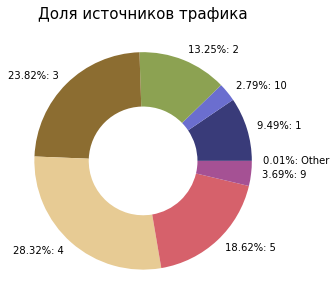

In [7]:
print('\nУникальные источники трафика:', sorted(list(visits.source_id.unique())))
print('Отдел маркетинга инвестирует в следующие источники:', sorted(list(costs.source_id.unique())))

pie_chart(visits, 'source_id', dec = 2, title = 'Доля источников трафика', 
          reduce_to = costs.source_id.unique())

Выглядит корректно: компания вкладывется в те источники, откуда приходит 99.9% пользователей. Расстраивает, что их названия закодированы - препятствует погружению в контекст. Сохраним номера этих источников в списке, чтобы при необходимости обратиться к ним. 

In [8]:
channels = list(costs.source_id.unique())

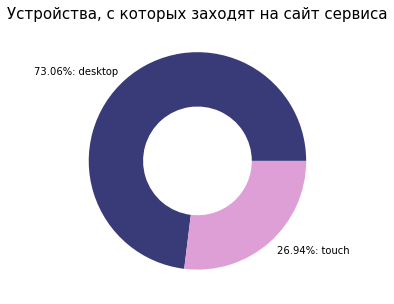

In [9]:
pie_chart(visits, 'device', dec = 2, title = 'Устройства, с которых заходят на сайт сервиса')

Все устройства относятся к одной из двух категорий: 'desktop' или 'touch'. В первую категорию, по всей вероятности, входят ПК и ноутбуки, во вторую - смартфоны и планшеты.

Посмотрим, за какой период получены данные

In [10]:
print('Начало наблюдений (таблица посещений):', visits.open.min())
print('Конец наблюдений (таблица посещений):', visits.open.max())
print('Начало наблюдений (таблица покупок):', orders.time_of_purchase.min())
print('Конец наблюдений (таблица покупок):', orders.time_of_purchase.max())

Начало наблюдений (таблица посещений): 2017-06-01 00:01:00
Конец наблюдений (таблица посещений): 2018-05-31 23:59:00
Начало наблюдений (таблица покупок): 2017-06-01 00:10:00
Конец наблюдений (таблица покупок): 2018-06-01 00:02:00


В таблицах данные за 12 полных месяцев. Но как минимум одна покупка попала в выборку из тринадцатого месяца (от начала отсчёта). Во избежание случайных ошибок её лучше не рассматривать.

In [11]:
orders = orders.drop(index = orders[ orders.time_of_purchase > '2018-06-01' ].index).reset_index(drop = True)

Проверим минимальную стоимость покупки.

In [12]:
print('Минимальная стоимость покупки -', orders['revenue'].min())

print('Покупок с такой стоимостью - {:.3%} от общего числа'.format(
       orders[ orders['revenue'] == orders['revenue'].min() ].shape[0] / orders.shape[0]) )

Минимальная стоимость покупки - 0.0
Покупок с такой стоимостью - 0.101% от общего числа


Баг репорт, и записи о покупках с нулевой стоимостью нужно удалить, иначе они будут учитаны при расчёте метрик.

In [13]:
orders = orders.drop(index = orders[ orders['revenue'] == 0 ].index).reset_index(drop = True)

Оценим теперь распределение столбца 'revenue', где записана выручка с каждой покупки. 

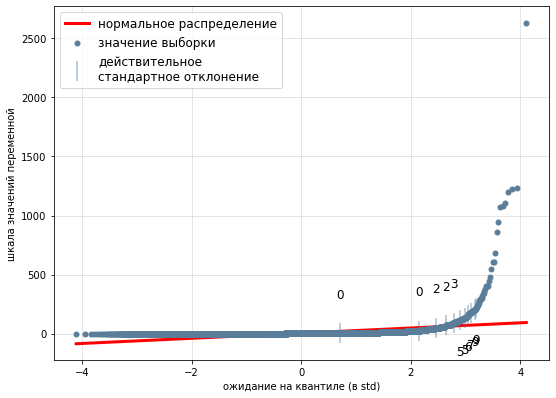

,Квантиль,Ожидание на квантиле (в std),Ожидание на квантиле (по мю и сигме),Значение выборки на квантиле,Значение std на квантиле
0,0.000020,-4.109155,-84.693274,0.01,-0.228814
1,0.000040,-3.946138,-81.134802,0.02,-0.228356
2,0.000060,-3.847904,-78.990467,0.03,-0.227898
3,0.000079,-3.776820,-77.438781,0.03,-0.227898


,Квантиль,Ожидание на квантиле (в std),Ожидание на квантиле (по мю и сигме),Значение выборки на квантиле,Значение std на квантиле
-4,0.999921,3.776820,87.448264,1195.640015,54.544186
-3,0.999940,3.847904,88.999950,1221.369995,55.722900
-2,0.999960,3.946138,91.144285,1236.280029,56.405945
-1,0.999980,4.109155,94.702756,2633.280029,120.403908



H0: Выборка подчиняется законам нормального распределения (распределена нормально)
                                   pvalue
Тест Колмогорова - Смирнова:        0.0
Тест Харке - Бера:                  0.0
Тест Шапиро - Уилка:                0.0
	- Отклоняем H0


In [14]:
is_normal(orders['revenue'], 0, no_hist = True)

Максимальное значение в 30 раз выше, чем должно быть при нормальном распределении. Около отметки в 3 std значение фактического распределения совпадает со значением гипотетического нормального (значит, к этому моменту пройдено более 99% выборки), а после этого "вытягивается" далеко направо - это наводит на мысль о том, что немногие энтузиасты обеспечивают непропорционально большую долю прибыли компании.

In [15]:
outliers_mask = st.zscore(orders.revenue) > 3.5
super_vip = orders.loc[ outliers_mask, 'uid' ].unique()

print('Доля покупок на сумму, превышающую средний чек на 3.5 std - {:.2%}'.format(
       outliers_mask.sum() / orders.shape[0]))
print('При этом выручка с этих покупок составляет {:.2%} от общей выручки'.format(
       orders.loc[ outliers_mask, 'revenue' ].sum() / orders.revenue.sum()))
print('{:.3%} клиентов обеспечивают 14.20% от выручки'.format(super_vip.shape[0] / orders.uid.nunique()))

Доля покупок на сумму, превышающую средний чек на 3.5 std - 0.31%
При этом выручка с этих покупок составляет 14.20% от общей выручки
0.211% клиентов обеспечивают 14.20% от выручки


В целом, никаких аномалий и ошибок не видно. Единственное, в дальнейшем стоит исключить из когортного анализа небольшую группу найденных только что клиентов - если какая-то часть из них попадёт в одну когорту, возникнут неправильные вопросы об особенностях этой когорты. 

<a id='target2'></a> 
## Источники трафика
[// вернуться к началу](#target100) 

Есть несколько метрик монетизации, которые подскажут, на что обратить внимание. Посчитаем их два раза: для всего бизнеса и в разрезе источников трафика.

In [16]:
def calc_unit(visits, orders, costs, fix = {}, to_print = True):
    def show(n, name):
        if name in fix.keys():
            if to_print:
                print('{: >6}'.format(name + ' ='), round(fix[name], 3))
            return {name: fix[name]}
        if to_print:
            print('{: >6}'.format(name + ' ='), round(n, 3))
        return {name: n}
    metrics = {}

    # User Acquisition - число привлеченных пользователей
    metrics.update(show(visits.uid.nunique(), 'UA'))

    # Conversion To 1 - коэффициент конверсии в совершение первой покупки
    metrics.update(show(orders.uid.nunique() / metrics['UA'], 'C1'))

    # Buyers - число платящих пользователей, или клиентов
    metrics.update(show(metrics['UA'] * metrics['C1'], 'B'))

    # Average Payment - средний чек
    metrics.update(show(orders.revenue.sum() / orders.shape[0], 'AvP'))

    # Average Payment Count - среднее число покупок, совершённых клиентов за время пользования сервисом
    metrics.update(show(orders.shape[0] / metrics['B'], 'APC'))

    # Acquisition Cost - маркетинговый бюджет
    metrics.update(show(costs.costs.sum(), 'AC'))

    # Cost Per Acquisition - стоимость привлечения одного пользователя
    metrics.update(show(metrics['AC'] / metrics['UA'], 'CPA'))

    # Avarege Revenue Per Customer - средняя прибыль с одного клиента без вычета 
    # маркетинговых затрат. сказано, что маржинальность сервиса - 100%, значит, 
    # переменных расходов компания не несёт, и прибыль равна доходу
    metrics.update(show((metrics['AvP'] * 1.00) * metrics['APC'], 'ARPC'))

    # Average Revenue Per User - средняя прибыль с посетителя
    metrics.update(show(metrics['ARPC'] * metrics['C1'], 'ARPU'))
    
    # Contribution Margin from Unit - валовая прибыль на 1 пользователя (с вычетом расходов на привлечение)
    metrics.update(show(metrics['ARPU'] - metrics['CPA'], 'CMU'))

    # Contribution Margin - валовая прибыль (с вычетом расходов на привлечение)
    metrics.update(show(metrics['UA'] * metrics['CMU'], 'CM'))

    # Return On Marketing Investments - коэффициент возврата маркетинговых инвестиций.
    # можно посчитать из абсолютных цифр (CM / СA), а можно из цифр на 1 юнита (CMU / CPA) 
    metrics.update(show(metrics['CMU'] / metrics['CPA'], 'ROMI'))
    return metrics

In [17]:
calc_unit(visits, orders, costs);

  UA = 228168
  C1 = 0.16
   B = 36508.0
 AvP = 5.005
 APC = 1.38
  AC = 329131.6
 CPA = 1.442
ARPC = 6.904
ARPU = 1.105
 CMU = -0.338
  CM = -77077.812
ROMI = -0.234


Взятый год принёс валовой убыток в размере 77 тысяч у.е. Компания заработала с одного пользователя 1.10 у.е., потратив на его привлечение 1.44 у.е. Конверсия нового пользователя в первую покупку составила $\frac{16}{100}$. За время пользования сервисом платящий пользователь совершил в среднем 1.4 покупку со средним чеком 5 у.е., итоговый доход с клиента - 6.9 у.е.

Если понимать конверсию как количество транзакций на количество сессий, то соотношение составит $\frac{50415}{359400}=\frac{14}{100}$.

Цель отдела маркетинга - оптимизировать бизнес-модель, перераспределив маркетинговый бюджет между источниками трафика. Вовлечём источники трафика в анализ следующим образом: сохраним в столбце 'initial_source' канал, откуда пользователь был впервые привлечён. В дальнейшем всю активность пользователя будет целесообразно приписывать именно этому каналу.

In [18]:
# сжойним 'visits' и таблицу с датой первого посещения для каждого пользователя, и из тех строк, 
# где дата начала сессии окажется равна дате первой сессии, заберём 'uid' пользователя и 'source_id'
initial_source = (visits.merge(visits.groupby('uid')['open'].min(), on = 'uid')
                  .query('open_x == open_y')[['uid', 'source_id']])
initial_source.columns = ['uid', 'initial_source']

if initial_source['uid'].is_unique:
    # сджойним 'orders' и 'initial_source'. убедимся, что в результате соединения никакие строки не задвоились
    a = orders.shape[0]
    orders = orders.merge(initial_source, on = 'uid', how = 'left')
    if a == orders.shape[0]:
        display(orders.head(3))
        visits = visits.merge(initial_source, on = 'uid', how = 'left')
    else:
        print(f'Ошибка. Было {a} строк, стало {orders.shape[0]}')

,time_of_purchase,uid,revenue,initial_source
0,2017-06-01 00:10:00,10329302124590727494,17.00,1
1,2017-06-01 00:25:00,11627257723692907447,0.55,2
2,2017-06-01 00:27:00,17903680561304213844,0.37,2


Нужно убедиться, что картина по источникам не сильно поменялась оттого, что за каждым пользователем оказался закреплён один источник.

In [19]:
compare_insrc_sources = visits[['source_id', 'initial_source']].value_counts(normalize = True).reset_index()
not_coincident = round(compare_insrc_sources.query('source_id != initial_source').iloc[:, -1].sum(), 2)
print(f'В {int((1 - not_coincident) * 100)}% посещений канал, откуда пришёл клиент\nсовпадает с каналом, откуда он был изначально привлечён.')

В 77% посещений канал, откуда пришёл клиент
совпадает с каналом, откуда он был изначально привлечён.


Порядок. Для начала, сравним распределение значений 'revenue' в разных группах.

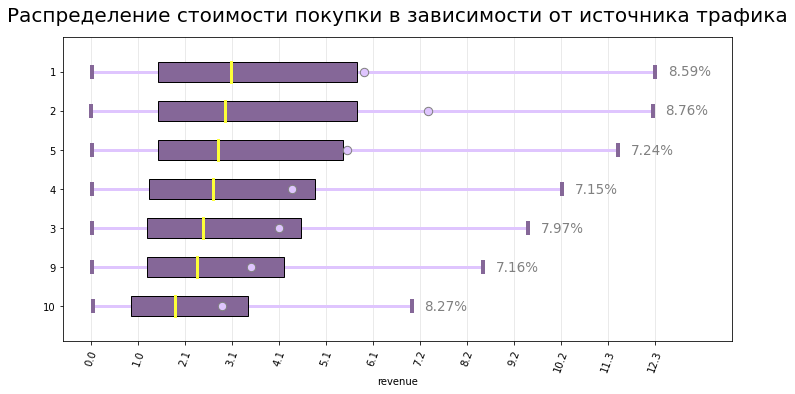

In [20]:
boxplot_sequence(orders[ orders.initial_source.isin(channels) ], 'initial_source', 'revenue', 
                 title = 'Распределение стоимости покупки в зависимости от источника трафика')

В распределённых ненормально выборках медиана более осмыслена, чем среднее. Боксплоты разных групп расположены как раз в порядке убывания их медианы. Однако обращает на себя внимание, что у группы киентов из источника №2
- среднее значение значительно выше, чем у клиентов из других групп.
- доля покупок, стоимость которых отклоняется от средней более чем на 1.5 iqr больше (доля 8.76%), чем у всех других групп. Проще говоря, "выбросов" у второй группы тоже больше

Убедимся, что источник трафика значимо предсказывает, какую сумму потратит клиент, пользуясь нашим сервисом 

In [21]:
lin_reg = ols('revenue ~ C(initial_source)', data = orders[ orders.initial_source.isin(channels) ]).fit()
anova = sm.stats.anova_lm(lin_reg)
display(anova.fillna(''))

,df,sum_sq,mean_sq,F,PR(>F)
C(initial_source),6.0,6.964872e+04,11608.120301,24.4284,4.54218e-29
Residual,50355.0,2.392818e+07,475.189719,,


Межгрупповой средний квадрат отклонения - 11608, в то время как внутригрупповой - 475. Это означает, что наибольшая часть дисперсии столбца 'revenue' обеспечена различием между группами, а не различиями внутри самих групп.

Зачастую бывает, что в итоговое F-значение дисперсионного анализа наибольший "вклад" вносят несколько резко выделяющихся групп. Чтобы выделить те группы, о которых будет достоверно известно, что они в лучшую сторону отличаются от остальных, выполним попарные сравнения с помощью критерия Тьюки.

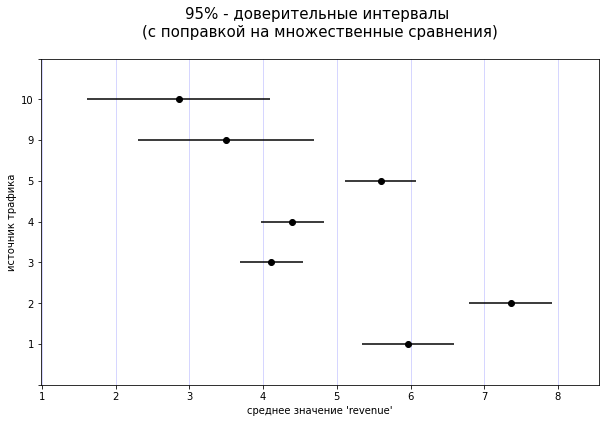

In [22]:
fig, ax = plt.subplots(figsize = ( 10,6 ))
(pairwise_tukeyhsd(orders[ orders.initial_source.isin(channels) ].revenue, 
                   orders[ orders.initial_source.isin(channels) ].initial_source)
                   .plot_simultaneous(ax = ax))
ax.set_title('95% - доверительные интервалы \n(с поправкой на множественные сравнения)', fontsize = 15, y = 1.05)
ax.set(ylabel = 'источник трафика', xlabel = "среднее значение 'revenue'")
ax.grid(b = True, axis = 'x', alpha = 0.2, color = 'blue')
display(fig)
plt.close(fig)

Остановимся на группах №2, №1 и №5. C вероятностью не менее 95% можно утверждать, что у клиентов из этих каналов средней чек выше, чем у других, что позволяет говорить о статистически значимом отличии. Рассчитаем коммерческие метрики отдельно для каждой группы.

In [23]:
isolated_metrics215 = pd.DataFrame(index = calc_unit(visits, orders, costs, to_print = False).keys())

for source_name in [2, 1, 5]:
    visits_slice = visits[ visits['initial_source'] == source_name ]
    orders_slice = orders[ orders['initial_source'] == source_name ]
    costs_slice = costs[ costs['source_id'] == source_name ]
    isolated_metrics215[source_name] = calc_unit(visits_slice, orders_slice, costs_slice, to_print = False).values()

display(isolated_metrics215)

,2,1,5
UA,17616.000000,9468.000000,49237.000000
C1,0.198853,0.305872,0.140768
B,3503.000000,2896.000000,6931.000000
AvP,7.357104,5.959469,5.594729
APC,1.820725,1.801450,1.357091
AC,42806.039062,20833.271484,51757.101562
CPA,2.429952,2.200388,1.051183
ARPC,13.395264,10.735687,7.592558
ARPU,2.663693,3.283751,1.068790
CMU,0.233740,1.083363,0.017607


Лучше всего окупились пользователи из первой группы (привлечённые из первого источника), принеся 149% от вложенной в них суммы, при этом от посетителей из других каналов они существенно отличаются только 30-процентной конверсией в первую покупку. Первая группа принесла 110% от вложенной суммы, у них наибольший средний чек из всех групп - 7.3 у.е., а в пятой группе (окупились на 101.6%) очень невысокая стоимость привлечения - 1.05 у.е. за посетителя.

Хочу отметить, что среднее значение 'revenue', послужившее основой для дисперсионного анализа, является лишь одной метрикой, для которой мы нашли значимые различия. Получается, что пользователи из разных групп могут приносить прибыль по-разному: одна группа может быть хороша конверсией, другая стоимостью привлечения пользователя. Рассчитаем метрики для остальных групп.

In [24]:
isolated_metrics34910 = pd.DataFrame(index = calc_unit(visits, orders, costs, to_print = False).keys())

for source_name in [3, 4, 9, 10]:
    visits_slice = visits[ visits['initial_source'] == source_name ]
    orders_slice = orders[ orders['initial_source'] == source_name ]
    costs_slice = costs[ costs['source_id'] == source_name ]
    isolated_metrics34910[source_name] = calc_unit(visits_slice, orders_slice, costs_slice, to_print = False).values()

display(isolated_metrics34910)

,3,4,9,10
UA,66116.000000,72346.000000,6448.000000,6903.000000
C1,0.158313,0.142302,0.168734,0.192235
B,10467.000000,10295.000000,1088.000000,1327.000000
AvP,4.110953,4.396883,3.496904,2.852776
APC,1.266839,1.252453,1.513787,1.175584
AC,141321.640625,61073.597656,5517.490234,5822.490234
CPA,2.137480,0.844188,0.855690,0.843472
ARPC,5.207914,5.506887,5.293567,3.353678
ARPU,0.824479,0.783643,0.893207,0.644695
CMU,-1.313001,-0.060545,0.037517,-0.198777


Компания понесла основные убытки из-за вложений в источник №3. Были вложены большие средства, но привлечь соответствующе много людей не удалось (66 тысяч пользователей против 72 тысяч от 4 группы, в которую вложили в два с половиной раза меньше), а активность клиентов оказалось на уровне ниже среднего. В результате №3 оказался самым невыгодным каналом привлечения - 61% вложенных в него средств не окупились.  

Могут обнадёжить показатели группы №9 - низкий средний чек компенсируются хорошим значением APC (частота покупок), стоимость привлечения (CPA) ниже суммарного дохода за lifetime (ARPU), благодаря чему в течение года вложения окупились. 
Так, но есть риски:
- группа №9 самая малочисленная, и, вероятно, увеличение затрат на привлечение пользователей из этого канала не даст кратного (или хотя бы ожидаемого) увеличения числа пользователей.
- доверительный интервал AvP девятой группы самый широкий. Вполне возможно, что истинное AvP окажется, допустим, на уровне десятой группы - 2.85 у.е. Но тогда, пересчитав метрики, обнаружим...

In [25]:
visits_slice = visits[ visits['initial_source'] == 9 ]
orders_slice = orders[ orders['initial_source'] == 9 ].copy()
costs_slice = costs[ costs['source_id'] == 9 ]
orders_slice['revenue'] = 2.852776
calc_unit(visits_slice, orders_slice, costs_slice);

  UA = 6448
  C1 = 0.169
   B = 1088.0
 AvP = 2.853
 APC = 1.514
  AC = 5517.49
 CPA = 0.856
ARPC = 4.318
ARPU = 0.729
 CMU = -0.127
  CM = -818.968
ROMI = -0.148


... что ушли в убыток. В итоге, можно порекомендовать инвестиции в 1, 2 и 5 источники. В каком размере? Чтобы ответить точно, нужно знать как изменяется CPA, то есть затраты на привлечение одного пользователя, при 
- увеличении вложений
- с течением времени

Если бы зависимость была линейная и при увеличении вложений в 4 раза мы получали бы в 4 раза больше пользователей, можно было бы без раздумий вкладывать все деньги в группу с наилучшим ROMI. Но на определенном этапе дальнейшие вложения перестают быть выгодными. В любом случае, вложенная в источник трафика сумма должна быть такой, чтобы стоимость привлечения одного пользователя не превышала суммарный доход от этого пользователя за lifetime (ARPU).
- за пользователя из канала №2 можно заплатить не больше 2.66 у.е.
- за пользователя из канала №1 можно заплатить не больше 3.28 у.е.
- за пользователя из канала №5 можно заплатить не больше 1.06 у.е.

Считается, что экономика компании будет стабильной при соотношении CPA / ARPU = 1/3

<a id='target3'></a>
## Маркетинговые затраты
[// вернуться к началу](#target100) 

С предыдущего раздела висит вопрос, как меняется стоимость пользователя в течение года, и нет ли в этих изменениях такой закономерности, которая могла бы подсказать нам, когда и в каком количестве инвестировать в трафик наиболее выгодно.
Для начала нужно определиться с тем, как мы считаем количество пользователей и стоимость привлечения. Пусть мы каждый месяц тратим на привлечение 200 рублей.

In [26]:
example = pd.DataFrame(columns = ['месяц_1', 'месяц_2'], index = ['когорта_1', 'когорта_2', '_________', 'вложения'])
example.iloc[:, 0:2] = [[1000, 100], ['', 1100], ['', ''], [300, 300]]
display(example)

,месяц_1,месяц_2
когорта_1,1000,100
когорта_2,,1100
_________,,
вложения,300,300


В первый месяц мы привлекли 1000 новых пользователей (цена за одного (CPA) $\frac{300}{1000} = 0.3$). Во второй месяц пришло 1200 пользователей, из них 1100 новых и 100 вернулись повторно. Сколько нам стоил один пользователь во втором месяце? 
- если нас интересует, сколько мы заплатили именно за новых пользователей - то заплатили 200 и получили 1100, цена за одного $\frac{300}{1100} = 0.27$. 
- если нас интересует, сколько суммарно людей посетило наш сайт за месяц, - то заплатили 200 и получили 1200, цена за одного $\frac{300}{1200} = 0.25$.

Если мы каждый месяц будем вычитать из знаменателя пользователей, которые уже были на сайте, то с каждым месяцем знаменатель будет всё меньше, отчего CPA - всё больше. Это связано с тем, что нельзя купить трафик, состоящий полностью из новых для сервиса людей. За клик "старого" пользователя компания заплатит столько же, сколько за клик "нового", хотя, разумеется, у первого и второго будет разная мотивация, и для компании они могут представлять разный интерес. Такое CPA (цена одних только новых пользователей) будет расти и выйдет на плато тогда, когда соотношение ежемесячно привлекаемых старых/новых пользователей сбалансируется - это произойдёт тогда, когда от самых первых когорт "отвалятся" все пользователя, то есть "цикл жизни" когорт сделает полный оборот. Значение CPA на этом плато и будет истинной ценой за нового пользователя (в начале наблюдений мы технически вынуждены всех пользователей считать новыми - у нас нет данных за более ранний период). 

Часть "старых" пользователей всегда будет возвращаться, не требуя с нашей стороны маркетинговых затрат. Если при расчёте CPA отталкиваться от суммарного количества привлечённых пользователей (а не от одних новых), то, если исклюить влияние посторонних причин, CPA должно оставаться на одном уровне, так как с первого месяца наблюдений уже есть какая-то часть таких пользователей. А если CPA падает, значит, нам удаётся расширить лояльную нам аудиторию. 

Построим на графике две кривые, соответствующие разным способам подсчёта CPA. 

In [27]:
# прибавим к дате вложений три дня, чтобы деньги, направленные после 27го\28го числа 
# (позднее чем за 3 дня до конца месяца), были отнесены к следующему месяцу.
costs['dt'] = costs['dt'].apply(lambda x: x + np.timedelta64(3, 'D')).astype('datetime64[M]')

# удалим вложения, направленные после 28го мая 2018, основной эффект от которых уже вне рассмотрения.
costs = costs[ costs['dt'] < '2018-06-01' ]

# сгруппируем по месяцу и источнику трафика
market_costs_grouped = costs.groupby(['dt', 'source_id'])['costs'].sum().reset_index()

# создадим таблицу, в которой сохранена дата первого посещения для каждого пользователя
visits['session_month'] = visits['open'].astype('datetime64[M]')
first_visit = visits.groupby('uid')['session_month'].min().reset_index()
first_visit.columns = np.append(first_visit.columns[:-1], 'first_session_month')

# джойним столбец с месяцем первого посещения и называем его 'first_session_month'
visits = visits.merge( first_visit, on = 'uid' )
orders = orders.merge( first_visit, on = 'uid' )

# называем когорты в формате 'ГГГГ-ММ'
visits['cohort'] = visits['first_session_month'].dt.strftime('%Y-%m')
orders['cohort'] = orders['first_session_month'].dt.strftime('%Y-%m')

# сохраним количество новых пользователей, привлеченных из каждого источника в каждый месяц
completely_new = visits.groupby(['first_session_month', 'initial_source'])['uid'].nunique().reset_index()
completely_new.columns = ['dt', 'source_id', 'ua_new_cnt']
market_costs_grouped = market_costs_grouped.merge(completely_new, on = ['dt', 'source_id'], how = 'left')

# вычислим и сохраним общее число уникальных пользователей в каждый месяц в столбец 'ua_total_cnt'
totals = visits.groupby(['session_month', 'source_id'])['uid'].nunique().reset_index()
totals.columns = ['dt', 'source_id', 'ua_total_cnt']
market_costs_grouped = market_costs_grouped.merge(totals, on = ['dt', 'source_id'], how = 'left')
market_costs_grouped = market_costs_grouped[['dt', 'source_id', 'costs', 'ua_new_cnt', 'ua_total_cnt']]

Вот так выглядит таблица, на основе которой будем рисовать график:

In [28]:
market_costs_grouped.tail(7)

,dt,source_id,costs,ua_new_cnt,ua_total_cnt
77,2018-05-01,1,1248.729980,732,1756
78,2018-05-01,2,2404.080078,1545,2964
79,2018-05-01,3,8225.759766,3836,5343
80,2018-05-01,4,4008.879883,5278,7275
81,2018-05-01,5,3125.790039,2972,4038
82,2018-05-01,9,322.609985,314,753
83,2018-05-01,10,377.890015,594,777


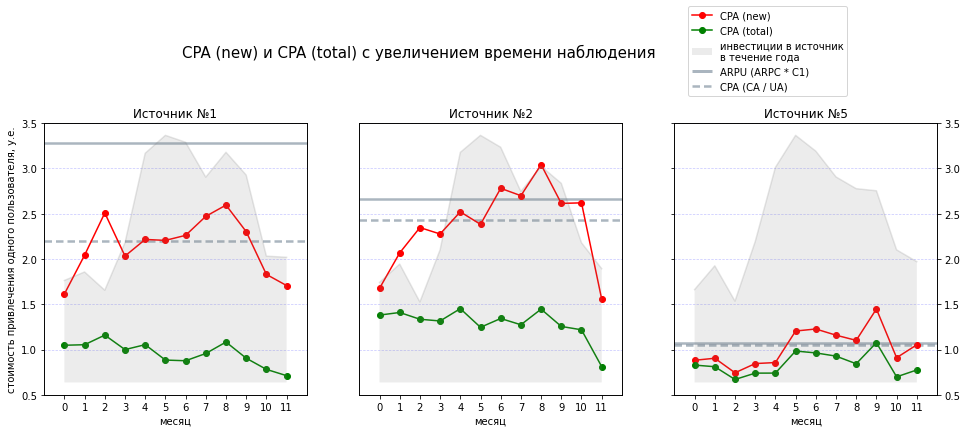

In [29]:
# рассчитаем помесячное CPA для каждого источника трафика 
source_1 = market_costs_grouped[ market_costs_grouped.source_id == 1 ]
source_2 = market_costs_grouped[ market_costs_grouped.source_id == 2 ]
source_5 = market_costs_grouped[ market_costs_grouped.source_id == 5 ]
for source_table in [source_1, source_2, source_5]:
    source_table['cpa_new'] = source_table['costs'] / source_table['ua_new_cnt']
    source_table['cpa_total'] = source_table['costs'] / source_table['ua_total_cnt']
    source_table.reset_index(drop = True, inplace = True)

# построим график, чтобы сразу видеть динамику
fig, (ax1, ax2, ax5) = plt.subplots(figsize = (16, 5), ncols = 3, nrows = 1, sharey = True, 
                                    subplot_kw = {'xticks': np.arange(0, 12), 'xlim': (-1, 12), 'ylim': (0.5, 3.5),
                                                  'xlabel': 'месяц'})
fig.suptitle('CPA (new) и CPA (total) с увеличением времени наблюдения', y = 1.1, x = 0.45, fontsize = 15)
ax1_c = plt.twinx(ax1)
ax2_c = plt.twinx(ax2)
ax5_c = plt.twinx(ax5)
for df, title, ax, ax_c in zip([source_1, source_2, source_5], [1, 2, 5], 
                               [ax1, ax2, ax5], [ax1_c, ax2_c, ax5_c]):
    ax.plot(df.index, df.cpa_new, marker = 'o', color = 'red')
    ax.plot(df.index, df.cpa_total, marker = 'o', color = 'green')
    ax.set_title('Источник №' + str(title), fontsize = 12)
    ax.hlines(isolated_metrics215.loc['ARPU', title], -1, 12, color = '#738595', linewidth = 2.5, alpha = 0.6)
    ax.hlines(isolated_metrics215.loc['CPA', title], -1, 12, color = '#738595', linewidth = 2.5, alpha = 0.6, 
              linestyle = 'dashed')
    ax.grid(b = True, axis = 'y', alpha = 0.2, color = 'blue', linestyle = 'dashed')
    ax_c.plot(df.index, df.costs, color = 'grey', alpha = 0.2)
    ax_c.fill_between(df.index, df.costs, 1, facecolor = 'grey', alpha = 0.15, 
                      label = 'инвестиции в источник\nв течение года')
    ax_c.tick_params(right = False, labelright = False)
ax2.tick_params(left = False, labelleft = False)
ax5.tick_params(right = True, labelright = True)
ax1.set_ylabel('стоимость привлечения одного пользователя, у.е.')
ax5_c.hlines([], [], [], color = '#738595', linewidth = 3, label = 'ARPU (ARPC * C1)', alpha = 0.6)
ax5_c.hlines([], [], [], color = '#738595', linewidth = 2.5, 
             alpha = 0.6, linestyle = 'dashed', label = 'CPA (CA / UA)')
ax5_c.plot([], [], marker = 'o', label = 'CPA (new)', color = 'red')
ax5_c.plot([], [], marker = 'o', color = 'green', label = 'CPA (total)')
ax5_c.legend(loc = (0.05, 1.1));

Инвестиции в источники выглядят единообразно, например, инвестиции во все источники достигли пика в октябре. Наводит на мысль, что в течение года бюджет менялся, но каждый раз его распределяли в некотором фиксированном соотношении. Если инвестиции достигли пика в октябре, это означает, что когорты 4-6 месяцев будут самыми большими, и что в ~6 месяце убыток компании достигнет отрицательного пика - на шестом месяце только что привлечённые с большими затратами когорты ещё не успеют хоть сколько-нибудь окупить инвестиции.

Проверим, действительно ли рекламный бюджет распределялся между каналами привлечения одинаково на протяжении всего года:

In [30]:
costs_monthly = pd.pivot_table(costs, columns = 'dt', index = 'source_id', values = 'costs', aggfunc = 'sum')
costs_monthly.columns = np.arange(0, 12)
for col in costs_monthly.columns:
    total_costs = costs_monthly[col].sum()
    costs_monthly[col] = costs_monthly[col].apply(lambda x: str(int((x / total_costs) * 100)) + '%')
budget = pd.pivot_table(costs, columns = 'dt', values = 'costs', aggfunc = 'sum').astype(int)
budget.columns = np.arange(0, 12)
budget_pct = budget.pct_change(axis = 1).mul(100).apply(round, args = (1,))
budget.index = ['месячный бюджет, у.е.']
budget_pct.index = ['процентное изменение, %']
costs_monthly = pd.concat([costs_monthly, pd.DataFrame(columns = np.arange(0, 12), index = ['']), 
                           budget, budget_pct])
costs_monthly.index.name = 'канал привлечения'
costs_monthly.columns.name = 'номер месяца'
display(costs_monthly.fillna(''))

номер месяца,0,1,2,3,4,5,6,7,8,9,10,11
канал привлечения,,,,,,,,,,,,
1,6%,5%,6%,6%,6%,6%,6%,6%,6%,6%,5%,6%
2,12%,13%,12%,12%,13%,14%,12%,12%,13%,13%,13%,12%
3,43%,41%,42%,42%,42%,44%,42%,44%,43%,42%,42%,41%
4,19%,19%,21%,20%,19%,13%,19%,17%,17%,18%,19%,20%
5,14%,16%,14%,15%,15%,17%,15%,15%,14%,15%,15%,15%
9,1%,1%,1%,1%,1%,1%,1%,1%,1%,1%,1%,1%
10,1%,1%,1%,1%,1%,2%,1%,1%,1%,1%,1%,1%
,,,,,,,,,,,,
"месячный бюджет, у.е.",16389,18559,14112,22931,36105,37239,39190,33443,33568,31930,21824,19713


Да, так и есть. Вернёмя к кривым CPA.

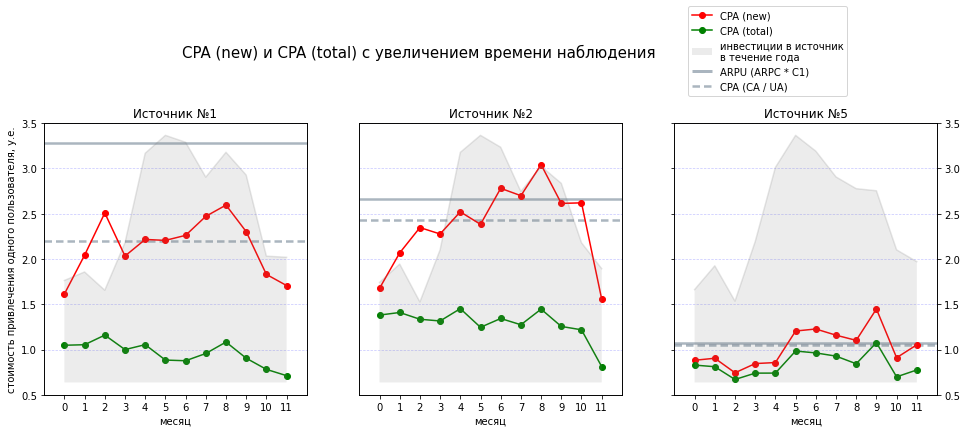

In [31]:
display(fig)
plt.close(fig)

Табличное значение CPA (количество пользователей, делёное на маркетинговый бюджет) оказалось на одном уровне с CPA (new). Это объясняется тем, что в числителе табличного CPA стоит число уникальных пользователей за всё время наблюдения. Но очевидно, что маркетинговый бюджет тратится на удержание и повторное привлечение старых пользователей наравне с привлечением новых поэтому неверно, не делая никаких оговорок, утверждать, что компания привлекает посетителей по цене CPA (new). 

Но CPA (total) - по сути то же самое, что CPA (new), у которого периодом наблюдения является не год, а месяц. Месяц тоже можно разбить на 12 частей (или сколько угодно) и посчитать CPA дважды:
- CPA как цену, заплаченную за каждого уникального пользователя в течение всего месяца ($\frac{месячный\:бюджет}{MAU}$)
- CPA как цену, заплаченную за каждого уникального пользователя в течение $\frac{1}{n}$-части месяца, и тогда в $\frac{2}{n}$-части месяца затраты на привлечение этого пользователя сновы будут посчитаны, и мы будем говорить, что учли его как "старого". Таким образом, выбор между CPA (new) и CPA (total) это выбор периода измерения.

Нетрудно убедиться, что если мы пересчитываем CPA для некоей части от общего времени наблюдения, то и UA пересчитывается соответственно. Тогда UA за всё время наблюдения будет суммой UA за каждый период, и будет значительно больше, чем UA, охватывающее всё время наблюдения разом. Но, подводя итог году ("всему времени наблюдения"), мы получим те же самые CM и ROMI. Поэтому выбор периода это вопрос удобства, выбор той или иной абстракции. Если бы отдел маркетинга запускал рекламные акции раз в десять дней, то, выбрав десятидневный период для расчёта метрик юнит-экономики, мы бы многое выигрывали в плане чёткости, детализации бизнес-процессов. Мы уже начали считать по месяцам, и нашим целям такой метод подсчёта вполне удовлетворяет.

Что же насчёт закономерностей? Их не видно: кривые не зависят ни от времени, ни от динамики инвестиций. 

<a id='target4'></a>
## Изменение метрик роста из месяца в месяц
[// вернуться к началу](#target100) 

Рассчитаем, как из месяца в месяц изменялось число людей в нескольких группах:
- уникальные пользователи (новые пользователи / старые пользователи)
- совершившие первую покупку / совершившие не первую покупку
- привлечено постоянных клиентов / отток постоянных клиентов
- сессий с устройств desktop / сессий с устройств touch

Подготовим данные и выведем на экран для проверки. Постоянными клиентами будем считать тех, кто совершил не меньше двух покупок на протяжении двух разных месяцев.

In [32]:
# уникальные пользователи (новые пользователи / старые пользователи)
mau = visits.groupby(['session_month'])['uid'].nunique().reset_index()
just_new = visits.groupby(['first_session_month'])['uid'].nunique().reset_index()
mau.columns = ['month', 'total_users_cnt']
just_new.columns = ['month', 'new_users_cnt']
month_summary = pd.merge(mau, just_new, on = 'month')

# вспомогательные столбцы
orders['month'] = orders.time_of_purchase.astype('datetime64[M]')
fsm = orders.groupby('uid')['month'].min().reset_index()
orders = pd.merge(orders, fsm, on = 'uid')
orders.columns = ['time_of_purchase', 'uid', 'revenue', 'initial_source',
                  'first_session_month', 'cohort', 'month', 'first_order_month']

# совершившие первую покупку / совершившие не первую покупку
# показывает соотношение и старых пользователей. поэтому новые пользователи,
# совершившие несколько покупок в первом месяце, относятся к новым.
first_orders = orders.groupby('first_order_month')['uid'].nunique().reset_index()
all_orders = orders.groupby('month')['uid'].nunique().reset_index()
first_orders.columns = ['month', 'first_time_buyers']
all_orders.columns = ['month', 'unique_buyers']
month_summary = pd.merge(month_summary, first_orders, on = 'month')
month_summary = pd.merge(month_summary, all_orders, on = 'month')

# сохранение постоянных клиентов / отток постоянных клиентов
last_orders = orders.groupby('uid')['time_of_purchase'].max().astype('datetime64[M]').reset_index()
last_orders.columns = ['uid', 'last_order_month']
casuals_and_addicted = orders.groupby('uid')['time_of_purchase'].count().reset_index()
casuals_and_addicted.columns = ['uid', 'transactions_cnt']
clients = pd.merge(orders.groupby('uid')['first_order_month'].first().reset_index(), last_orders, on = 'uid')
clients = pd.merge(clients, casuals_and_addicted, on = 'uid')
clients['months_of_lifetime'] = round((clients.last_order_month - clients.first_order_month) 
                                            / np.timedelta64(1, 'M')).astype('int')
# если клиент в среднем делает меньше одной покупки в месяц, то месяц без покупки нельзя  
# считать месяцем, когда клиент был потерян
clients['orders_per_month'] = clients.transactions_cnt / (clients.months_of_lifetime + 1)
def calc_loss_date(row):
    if row['orders_per_month'] >= 1:
        return (row['last_order_month'] + np.timedelta64(32, 'D'))
    return row['last_order_month'] + np.timedelta64(int(np.ceil(1 / row['orders_per_month'])) * 32, 'D')
clients['loss_date'] = clients.apply(calc_loss_date, axis = 1).astype('datetime64[M]')

# совершившие одну покупку / совершившие несколько покупок
# показывает соотношение спонтанным покупок к регулярным
device_sess = visits.groupby(['session_month', 'device'])['uid'].count().unstack()
device_sess.columns = ['desktop_sessions', 'touch_sessions']
device_sess = device_sess.reset_index()
device_sess.columns = ['month', 'desktop_sessions', 'touch_sessions']
month_summary = pd.merge(month_summary, device_sess, on = 'month')
olds = clients[ clients.months_of_lifetime > 0 ]

display(month_summary.head())
display(clients[ clients['transactions_cnt'] > 1 ].head(2))
display(clients[ clients['orders_per_month'] < 1 ].head(2))

,month,total_users_cnt,new_users_cnt,first_time_buyers,unique_buyers,desktop_sessions,touch_sessions
0,2017-06-01,13259,13259,2022,2022,12358,4147
1,2017-07-01,14183,13140,1922,1983,12950,4878
2,2017-08-01,11631,10181,1369,1471,10854,3501
3,2017-09-01,18975,16704,2579,2748,17356,6551
4,2017-10-01,29692,25977,4340,4673,27392,10511


,uid,first_order_month,last_order_month,transactions_cnt,months_of_lifetime,orders_per_month,loss_date
1,1575281904278712,2017-06-01,2017-06-01,2,0,2.0,2017-07-01
4,2551852515556206,2017-11-01,2017-11-01,2,0,2.0,2017-12-01


,uid,first_order_month,last_order_month,transactions_cnt,months_of_lifetime,orders_per_month,loss_date
22,16118742129536584,2017-09-01,2018-01-01,4,4,0.800000,2018-03-01
46,27988737487879574,2017-12-01,2018-02-01,2,2,0.666667,2018-04-01


Всё посчиталось верно, рисуем подходящие графики.

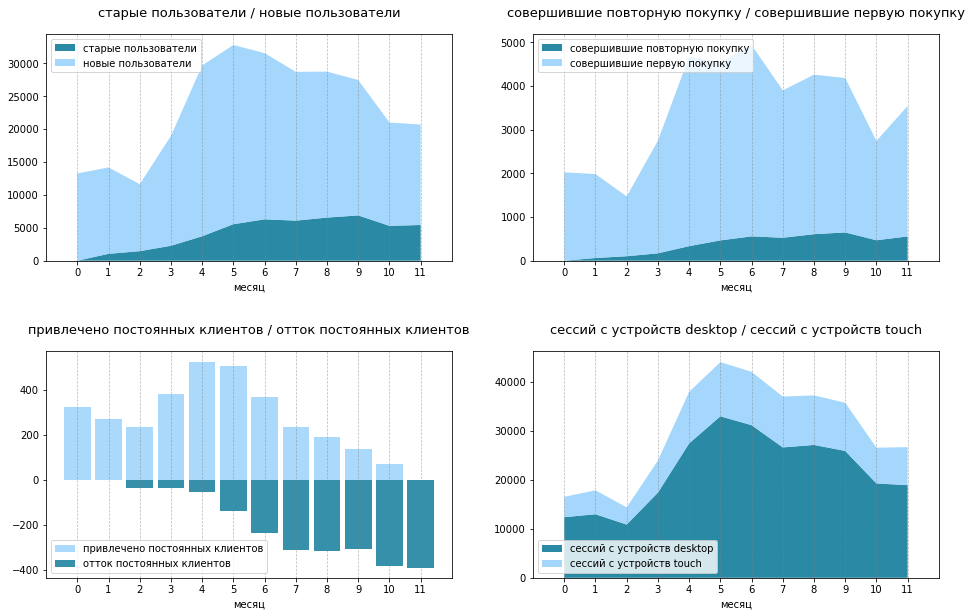

In [33]:
fig = plt.figure(figsize = (16, 10))
grid = fig.add_gridspec(2, 2, wspace = 0.2, hspace = 0.4)
ax_ua = fig.add_subplot(grid[0, 0]); ax_dev = fig.add_subplot(grid[1, 1]); 
ax_c = fig.add_subplot(grid[0, 1]); ax_rr = fig.add_subplot(grid[1, 0])
x = np.arange(0, 12)

titles = [['старые пользователи', 'новые пользователи'], 
          ['сессий с устройств desktop', 'сессий с устройств touch'],
          ['привлечено постоянных клиентов', 'отток постоянных клиентов'], 
          ['совершившие повторную покупку', 'совершившие первую покупку']]

ax_ua.stackplot(x, [month_summary.total_users_cnt - month_summary.new_users_cnt, month_summary.new_users_cnt], 
                labels = titles[0], colors = ['#047495', '#95d0fc'], alpha = 0.85)
ax_dev.stackplot(x, [month_summary.desktop_sessions, month_summary.touch_sessions], 
                 labels = titles[1], colors = ['#047495', '#95d0fc'], alpha = 0.85)
ax_c.stackplot(x, [month_summary.unique_buyers - month_summary.first_time_buyers, month_summary.first_time_buyers], 
               labels = titles[3], colors = ['#047495', '#95d0fc'], alpha = 0.85)

acquisited = olds.groupby('first_order_month')['uid'].count()
lost = olds[ olds.loss_date.dt.date < pd.Timestamp('2018-06-01 00:00:00') ].groupby('loss_date')['uid'].count() * -1
ax_rr.bar(acquisited.reset_index().index, acquisited, 
          color = '#95d0fc', alpha = 0.8, width = 0.85, label = titles[2][0])
ax_rr.bar(lost.reset_index().set_index(np.arange(2, 12)).index, lost, 
          color = '#047495', alpha = 0.8, width = 0.85, label = titles[2][1])

for ax, title in zip([ax_ua, ax_dev, ax_rr, ax_c], titles):
    ax.set_title(title[0] + ' / ' + title[1], fontsize = 13, y = 1.05)
    ax.set(xticks = np.arange(0, 12), xlim = (-1, 12), xlabel = 'месяц')
    ax.grid(b = False, axis = 'y')
    ax.grid(axis = 'x', color = 'grey', linestyle = '--', alpha = 0.5)
    
ax_rr.legend(loc = 'lower left')
ax_dev.legend(loc = 'lower left')
ax_ua.legend(loc = 'upper left')
ax_c.legend(loc = 'upper left')
display(fig)
plt.close(fig)

С метриками роста все неплохо. Число уникальных пользователей в месяц достигло 31 000 человек в ноябре, затем медленно снижалось, но в конце года всё равно оказалось выше, чем в начале. Похожая история и с уникальными покупателями. Обращает на себя внимание низкая доля повторных покупок среди всех покупок (обратимся к этой зацепке позже). Сессий с устройств desktop на протяжении всего года примерно в три раза больше, чем с touch, соотношение ощутимо не изменяется. Заметно также, что кривая числа сессий идёт вровень с кривой MAU (если первый график наложить на четвёртый, контуры совпадут) - это означает, что за весь год показатель среднего числа сессий на посетителя не сильно изменился.

Интересная ситуация с привлечением и оттоком постоянных клиентов. Само собой, чем больше привлечёшь - тем больше уйдёт. Даже если из десяти привлечённых уйдут девять, успех маркетинговой компании можно оценивать одним оставшимся. Однако же, во-первых, лучше, чтобы не уходили (над этим понятно как работать - за каждым потерянным постоянным клиентом обычно стоит несложная история), а, во-вторых, привлечение каждого постоянного клиента стоит каких-то денег и несёт потенциальную прибыль, поэтому ущерб от потери девяти постоянных клиентов из десяти может быть несопоставим с выгодой от одного оставшегося. По третьему графику приблизительно видно, что почти все, кого в течение года удалось привлечь, к концу года были потеряны.


Постоянными, напомню, считаем тех, кто совершил не менее двух покупок на протяжении двух разных месяцев. Заложено в определении, что у нас не может быть оттока в первые два месяца наблюдения, а за последний месяц не может быть привлечено новых постоянных клиентов. Также напомню, что потерянным, к примеру, в январе считается тот клиент, который должен был, согласно частоте, с которой он покупал до этого, совершить хотя бы одну покупку в январе, но этого не сделал, и впоследствии тоже ничего не покупал.

<a id='target5'></a>
## Длительность сессии, desktop и touch устройства
[// вернуться к началу](#target100) 

Сохраним длительность пребывания на сайте (в минутах) в столбец 'duration'. Построим график его распределения.

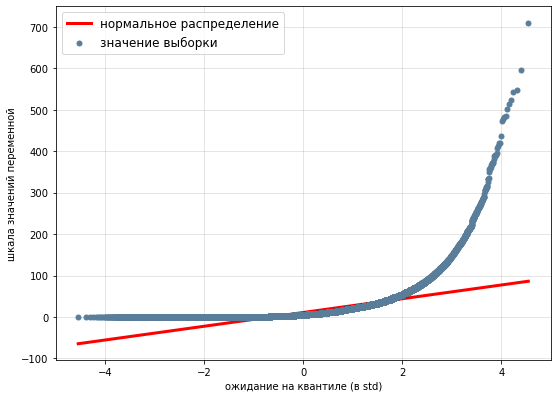


H0: Выборка подчиняется законам нормального распределения (распределена нормально)
                                   pvalue
Тест Колмогорова - Смирнова:        0.0
Тест Харке - Бера:                  0.0
Тест Шапиро - Уилка:                0.0
	- Отклоняем H0

Среднее время посещения -  10.7 минут. Медиана -  5 минут


In [34]:
visits['duration'] = round((visits['close'] - visits['open']) / np.timedelta64(1, 'm'), 2)
is_normal(visits['duration'], 0, no_hist = True, no_std_ticks = True, no_qq_table = True)
print('\nСреднее время посещения - ', round(visits['duration'].mean(), 1), 'минут. Медиана - ', 
      int(visits['duration'].median()), 'минут')

С "левой" стороны от медианы - огромное количество посещений с короткой длительностью, однако из-за того как сильно отметки на Y масштабированы выбросами, толком не понять - это "шум" наподобие сессий с длительностью в несколько секунд, либо же посещения, сопоставимые по длительности с медианой. В принципе, это не так важно.

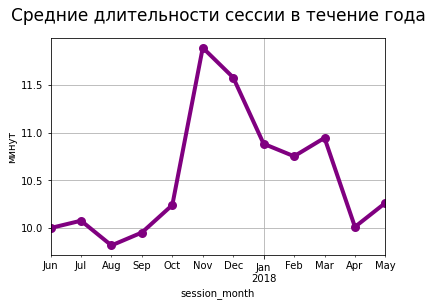

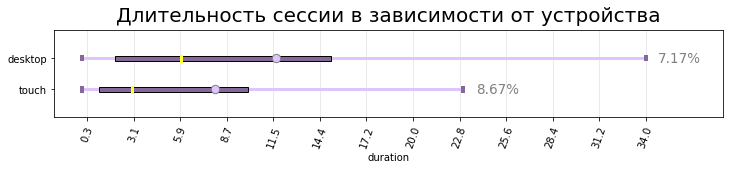

In [35]:
visits.groupby('session_month')['duration'].mean().plot(ylabel = 'минут', color = 'purple', 
                                                        linewidth = 4, marker = 'o', mew = 3)
plt.gca().set_title('Средние длительности сессии в течение года', fontsize = 17, y = 1.05)
plt.gca().grid(b = True, axis = 'both')
plt.show()
print()
boxplot_sequence(visits, 'device', 'duration', 
                 title = 'Длительность сессии в зависимости от устройства')

In [36]:
desktop_d = visits.loc[ visits.device == 'desktop', 'duration']
touch_d = visits.loc[ visits.device == 'touch', 'duration']
if st.levene(desktop_d, touch_d).pvalue < 0.05:
    results = st.ttest_ind(desktop_d, touch_d, equal_var = False)
else:
    results = st.ttest_ind(desktop_d, touch_d, equal_var = True)
print('\nT-значение =', round(results.statistic, 2), '\nP-value равенства средних =', results.pvalue)


T-значение = 70.09 
P-value равенства средних = 0.0


Сессий с устройств 'desktop' больше, и длятся они значимо дольше, но кажется, что в этом сказывается принципиальное различие между 'desktop' и 'device'. Выгодна ли одна группа больше другой? Получим список пользователей, которые пользовались устройствами только одного типа и присоединим результат к таблице с транзакциями. Выполним парный t-test и нарисуем доверительные интервалы средних.

In [37]:
consistent_devices_uids = visits.groupby('uid')['device'].nunique().reset_index()
mapper = visits.merge(consistent_devices_uids[consistent_devices_uids.device == 1], on = 'uid', how = 'inner')
mapper['device'] = mapper['device_x'].astype('str')
mapper = mapper.groupby('uid')['device'].first().reset_index()
display(mapper.head(3))
orders = orders.merge(mapper, on = 'uid')
desktop_rev = orders.loc[ orders.device == 'desktop', 'revenue']
touch_rev = orders.loc[ orders.device == 'touch', 'revenue']

,uid,device
0,11863502262781,touch
1,49537067089222,touch
2,297729379853735,desktop


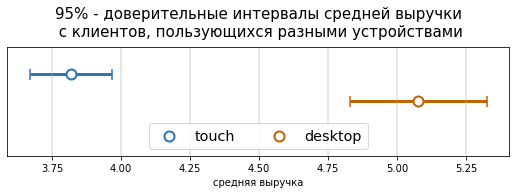


T-значение = 8.55 
P-value равенства средних = 1.321416027773973e-17 
Расстояние между доверительными интервалами = 0.86


In [38]:
if st.levene(desktop_rev, touch_rev).pvalue < 0.05:
    results = st.ttest_ind(desktop_rev, touch_rev, equal_var = False)
else:
    results = st.ttest_ind(desktop_rev, touch_rev, equal_var = True)

fig, ax = plt.subplots(figsize = (9, 2), subplot_kw = {'ylim': (0, 2), 'xlabel': 'средняя выручка'})
ax.set_title('95% - доверительные интервалы средней выручки\n с клиентов, пользующихся разными устройствами', 
             fontsize = 15, y = 1.05)
mu_first = np.mean(desktop_rev)
mu_second = np.mean(touch_rev)
sigma_first = np.std(desktop_rev)
sigma_second = np.std(touch_rev) 
SE_first = (sigma_first / np.sqrt(len(desktop_rev)))
SE_second = (sigma_second / np.sqrt(len(touch_rev)))
range_inside_95 = st.norm.interval(0.95, 0, 1)
conf_first = [mu_first + (SE_first * r) for r in range_inside_95]
conf_second = [mu_second + (SE_second * r) for r in range_inside_95]
for y, mu, conf, color, name in zip([1.5, 1], [mu_second, mu_first], [conf_second, conf_first], 
                                              ['#2976bb', '#be6400'], ['touch', 'desktop']):
    ax.hlines(y = y, xmin = conf[0], xmax = conf[1], color = color, lw = 3, zorder = 1)
    ax.vlines(x = conf, ymin = y - 0.1, ymax = y + 0.1, color = color, lw = 1.5, zorder = 1)
    ax.scatter(mu, y, color = 'white', s = 100, linewidths = 2, edgecolors = color, 
               label = name, zorder = 2)
    ax.legend(loc = 'lower center', fontsize = 'x-large', ncol = 2)
ax.grid(b = True, axis = 'x', alpha = 0.3, linewidth = 2)
ax.tick_params(labelleft = False, left = False)
display(fig)
plt.close(fig)
print('\nT-значение =', round(results.statistic, 2), '\nP-value равенства средних =', results.pvalue, 
      '\nРасстояние между доверительными интервалами =', round(conf_first[0] - conf_second[1], 2))

С клиентов, пользующихся устройствами desktop, средняя выручка значимо выше. Разница выборочных средних - 1.5 у.е, а разница истинных средних при уровне значимости 0.05 будет не меньше 0.86 у.е.

<a id='target6'></a>
## Конверсия во вторую покупку
[// вернуться к началу](#target100) 

У нас APC, то есть число повторных покупок, в среднем на клиента 1.38 - это немного. И у нас был график, на котором повторных покупок оказалось как-то мало по отношению к первым покупкам. Эти два наблюдения подталкивают посчитать конверсию во вторую покупку.

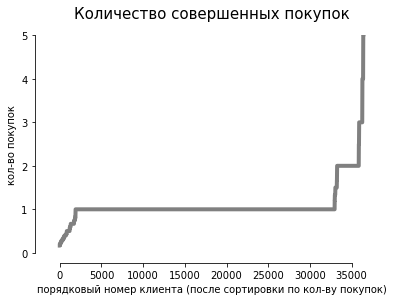

Средняя продолжительность пользования сервисом - 0.31 месяцев


In [39]:
(clients['orders_per_month'].sort_values().reset_index(drop = True)
 .plot(ylim = (0, 5), ylabel = 'кол-во покупок', 
       xlabel = 'порядковый номер клиента (после сортировки по кол-ву покупок)',
       linewidth = 4, color = 'grey'))
plt.gca().set_title('Количество совершенных покупок', fontsize = 15, y = 1.05)
sns.despine(offset = 10, trim = True)
plt.show()
print('Средняя продолжительность пользования сервисом -', round(clients.months_of_lifetime.mean(), 2), 'месяцев');

Подавляющее большинство клиентов "живёт" меньше месяца и ограничивается одной покупкой.

In [40]:
print(f'Конверсия из первой покупки во вторую покупку составляет \
      {round((clients[ clients.transactions_cnt > 1 ].shape[0] / clients.shape[0]) * 100, 1)}%')

Конверсия из первой покупки во вторую покупку составляет       17.2%


Конверсия в первую покупку составляет 16% - отличный показатель. О чём говорит такая высокая цифра? 
- пользователям удобно выбирать и оплачивать товары, 
- находят предложение выгодным,
- доверяют продавцу
- возможно, приняли решение о покупке ещё до того, как зашли на сайт

Но конверсия во вторую покупку после первой находится на одном уровне с конверсией из посетителя в первую покупку, а это низкий показатель. Выдвинем гипотезу: ни продукт, ни бренд не представляют для клиентов особой ценности. Когда клиенты пользуются услугами сервиса от случая к случаю и хотят получить "типовый" продукт (такой как билеты), им нет разницы, чьим предложением они воспользуются. Поэтому критически важно, чтобы сервис был в верхней строчке поисковой выдачи, чем объясняется потребность в постоянных, растущих инвестициях в продвижение.

Целевая группа в нашем случае - это клиенты, которые пользуются сервисом всякий раз, когда им захочется попасть на какое-то культурное мероприятие. Которых не нужно "возвращать". Будем считать целевыми клиентами тех, которые за пять месяцев купят у нас билеты трижды. Значение 'orders_per_month' будет равно $\frac{3}{5} = 0.6$. Отсечём клиентов, пришедших после февраля 2018 (поскольку у нас наблюдения только до конца мая) и посчитаем конверсию из второй покупки в целевого клиента.

In [41]:
target_slice = clients[ (clients.orders_per_month >= 0.6) & (clients.months_of_lifetime >= 4) ]
C_target = round((target_slice.shape[0] / clients[ (clients.months_of_lifetime >= 4)].shape[0]) * 100, 1)
print(f'Конверсия из второй покупки в целевую активность составляет {C_target}%')

Конверсия из второй покупки в целевую активность составляет 27.7%


Значит, 78.3% из тех, кто совершил две или более покупок, пользуются сервисом нерегулярно, от случая к случаю. Если принять гипотезу, то это - недостаточно часто, чтобы выработалась привычка к продукту, отчего время от времени их нужно привлекать заного. 

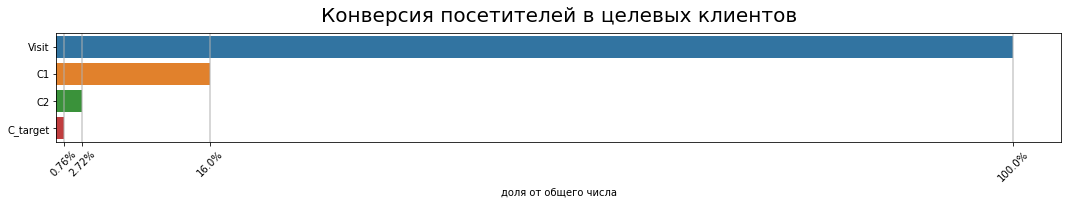

In [42]:
fig, ax = plt.subplots(figsize = (18, 2))
funnel = pd.Series([0, 1, 2, 3]).map({0: 100, 1: 16, 2: (0.16 * 0.17) * 100, 
                                      3: (0.16 * 0.172 * 0.277) * 100}).reset_index()
funnel.columns = ['', 'доля от общего числа']
funnel[''] = funnel[''].astype('str')
ax.grid(b = True, axis = 'x', alpha = 0.5, linewidth = 2)
sns.barplot(y = '', x = 'доля от общего числа', data = funnel, zorder = 1)
ax.set_yticklabels(['Visit', 'C1', 'C2', 'C_target'])
ax.set_xticks(funnel['доля от общего числа'])
ax.set_xticklabels(funnel['доля от общего числа'].round(2).astype('str') + '%', rotation = 45)
ax.set_title('Конверсия посетителей в целевых клиентов', fontsize = 20, y = 1.05)
display(fig)
plt.close(fig)

Рассчитаем время от первого визита до первой покупки у тех 16% пользователей, которые совершили первую покупку. Если мы обнаружим, что в случае большинства пользователей это время очень невелико, это будет подтверждением того, что сервисом пользуются:
- для совершения спонтанных и единовременных покупок (если бы искали на долгий срок, тратили бы больше времени на изучение информации)
- для совершения покупок, решение о которых приняли ещё до того, как зашли на сайт

А это, в свою очередь, косвенно подтвердит гипотезу о том, что в этой нише ни продукт, ни бренд не представляют для клиентов особой ценности.

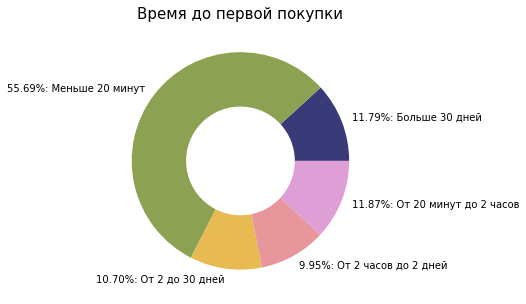

In [43]:
fs_order = orders.groupby('uid')['time_of_purchase'].min().reset_index()
fs_visit = visits.groupby('uid')['open'].min().reset_index()
fs_order_visit = pd.merge(fs_visit, fs_order, on = 'uid', how = 'inner')
fs_order_visit.columns = ['uid', 'first_session', 'first_order']
fs_order_visit['time_until_first_purchase'] = fs_order_visit.first_order - fs_order_visit.first_session

def to_categories(time_until_first_purchase):
    if time_until_first_purchase > np.timedelta64(30, 'D'):
        return 'Больше 30 дней'
    elif time_until_first_purchase > np.timedelta64(2, 'D'):
        return 'От 2 до 30 дней'
    elif time_until_first_purchase > np.timedelta64(2, 'h'):
        return 'От 2 часов до 2 дней'
    elif time_until_first_purchase > np.timedelta64(20, 'm'):
        return 'От 20 минут до 2 часов'
    return 'Меньше 20 минут'

fs_order_visit['time_until_first_purchase_cat'] = fs_order_visit['time_until_first_purchase'].apply(to_categories)
pie_chart(fs_order_visit, 'time_until_first_purchase_cat', dec = 2, title = 'Время до первой покупки')

Больше половины первых покупок севершаются в срок менее двадцати минут. Больше 65% - в срок до двух часов. Проверим, отличаются ли спонтанные покупатели от непокупающих пользователей и от целевых клиентов длительностью сессии. Поставим 0 напротив пользователей, 2 напротив клиентов с целевой активностью, 1 напротив остальных клиентов.

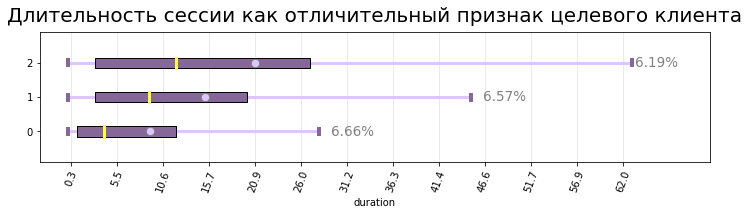

In [44]:
visits['is_target'] = visits.uid.isin(orders.uid.unique()).astype('int')
visits.loc[visits.uid.isin(target_slice.uid.unique()), 'is_target'] = 2
boxplot_sequence(visits, 'is_target', 'duration', 
                 title = 'Длительность сессии как отличительный признак целевого клиента')

Не будем проверять статистическую значимость этого отличия, потому что, в принципе, и так видно, чем это закончится. Длительность сессии отличает как клиентов от обычных посетителей, так и целевых клиентов от клиентов, совершающих редкие или единовременные покупки. Целевой клиент проводит на сайте в среднем 21 минуту в день (или 12 минут, если судить по медиане). 

Посчитаем ещё один показатель - для тех, кто попадает на сайт от случая к случаю, среднее число сессий в день не должно сильно превышать единицу.

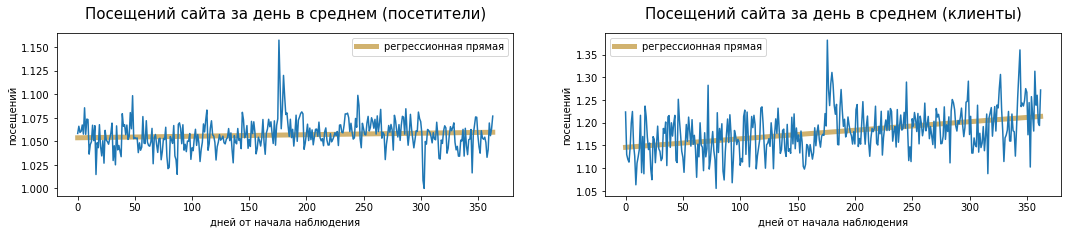

За один день пользователи заходят на сайт в среднем 1.06 раз
За один день клиенты заходят на сайт в среднем 1.19 раз
За один день целевые клиенты заходят на сайт в среднем 1.466 раз


In [45]:
visits['session_day'] = visits['open'].astype('datetime64[D]')
visits_per_user = (visits[ visits.is_target == 0 ].groupby(['uid', 'session_day'])['open'].count().reset_index())
visits_per_user_daily = visits_per_user.groupby('session_day')['open'].mean().reset_index()

visits_per_client = (visits[ visits.is_target != 0 ].groupby(['uid', 'session_day'])['open'].count().reset_index())
visits_per_client_daily = visits_per_client.groupby('session_day')['open'].mean().reset_index()

visits_per_target = (visits[ visits.is_target == 2 ].groupby(['uid', 'session_day'])['open'].count().reset_index())

fig, ax = plt.subplots(1, 2, figsize = (18, 3))
for ax, df, title in zip(ax, [visits_per_user_daily, visits_per_client_daily], ['посетители', 'клиенты']):
    lin_reg = ols('open ~ index', data = df.reset_index()).fit().params
    ax.set_title('Посещений сайта за день в среднем' + f' ({title})', fontsize = 15, y = 1.05)
    ax.set(xlabel = 'дней от начала наблюдения', ylabel = 'посещений')
    ax.plot(df.index, lin_reg['Intercept'] + lin_reg['index'] * df.index,
            linewidth = 5, color = '#d1b26f', label = f'регрессионная прямая')
    ax.plot(df.index, df.open)
    ax.legend()

print()
display(fig)
plt.close(fig)
print(f'За один день пользователи заходят на сайт в среднем {round(visits_per_user.open.mean(), 3)} раз')
print(f'За один день клиенты заходят на сайт в среднем {round(visits_per_client.open.mean(), 3)} раз')
print(f'За один день целевые клиенты заходят на сайт в среднем {round(visits_per_target.open.mean(), 3)} раз')

Так и есть. Среди клиентов в течение года был рост, но незначительный - метрика выросла примерно на 6%. Среди клиентов дисперсия средних посещений за день более выражена, что должно быть связано с небольшим размером выборок активных клиентов за день. Целевых клиентов от остальных групп отличает более высокое среднее число сессий за день.

<a id='target7'></a>
## Когорты
[// вернуться к началу](#target100) 

In [46]:
# вычисляем порядковый номер месяца (от первого посещения) для покупок и для сессий 
visits['lifetime'] = round((visits.open.astype('datetime64[M]') - visits.first_session_month) 
                           / np.timedelta64(1, 'M')).astype('int')
orders['lifetime'] = round((orders.time_of_purchase.astype('datetime64[M]') - orders.first_session_month) 
                           / np.timedelta64(1, 'M')).astype('int')

# создаём сводные таблицы
slice_orders = orders[ orders['uid'].isin(super_vip) == False ]
buyers_cnt = orders.pivot_table(index = 'cohort', columns = 'lifetime', values = 'uid', aggfunc = 'nunique')
orders_total = orders.pivot_table(index = 'cohort', columns = 'lifetime', values = 'uid', aggfunc = 'count')
retention = buyers_cnt.div(buyers_cnt[0], axis = 0)
retention_mask = retention.astype('bool')
retention_mask.iloc[:, 1:] = False

In [47]:
def coh_unit(n = False):
    if n:
        slice_n = slice_orders[ slice_orders['initial_source'] == n ]
        users = visits[ visits['initial_source'] == n ].pivot_table(index = 'cohort', columns = 'lifetime', 
                                                                    values = 'uid', aggfunc = 'nunique')[0]
        visits_slice = visits[ visits['initial_source'] == source_name ]
        orders_slice = orders[ orders['initial_source'] == source_name ]
        costs_slice = costs[ costs['source_id'] == source_name ]
        unit_overall = calc_unit(visits_slice, orders_slice, costs_slice, to_print = False)
    else:     
        slice_n = slice_orders
        users = visits.groupby('cohort')['uid'].nunique()
    buyers = slice_n.pivot_table(index = 'cohort', columns = 'lifetime', values = 'uid', aggfunc = 'nunique')[0]
    comm = slice_n.groupby(['cohort', 'lifetime']).agg({'revenue': 'sum', 'uid': 'count'})
    comm['avp'] = comm.revenue.div(comm.uid)
    comm['arpc'] = comm.revenue.div(buyers, axis = 0)
    comm['arpu'] = comm['arpc'].mul(buyers.div(users))
    if n:
        comm['romi'] = (comm['arpu'].unstack().cumsum(axis = 1)
                                              .sub(unit_overall['CPA']).div(unit_overall['CPA']).stack())
    return comm

In [48]:
def two_subplots(titles):
    fig = plt.figure(figsize = (18, 5.5))
    grid = fig.add_gridspec(1, 2, wspace = 0.25)
    ax1 = fig.add_subplot(grid[0, 0]); ax2 = fig.add_subplot(grid[0, 1])
    for ax, title in zip([ax1, ax2], titles):
        ax.tick_params(bottom = False, labelbottom = False, top = True, labeltop = True)
        ax.xaxis.set_label_position('top')
        ax.set_title(title, y = 1.15, fontsize = 15)
    return fig, ax1, ax2

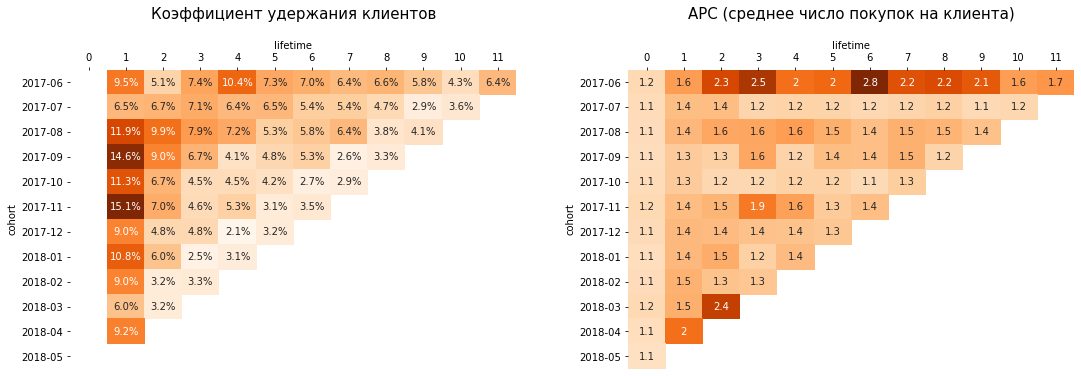

In [49]:
fig, ax_rr, ax_apc = two_subplots(['Коэффициент удержания клиентов', 
                                   'APC (среднее число покупок на клиента)'])
sns.heatmap(retention, annot = True, cmap = 'Oranges', fmt = '.1%', mask = retention_mask, cbar = False, ax = ax_rr)
sns.heatmap(orders_total / buyers_cnt, annot = True, cmap = 'Oranges', vmin = 0.75, cbar = False, ax = ax_apc)
display(fig)
plt.close(fig)

Нулевой месяц Retention не показан, потому что в нулевой месяц он всегда равен 100%. Ещё нужно отметить, что коэффициент удержания рассчитали для покупок, а не для посещений, и для когорт клиентов (совершившие первую покупку в такой-то месяц), а не пользователей. Почему так? Retention покупок для пользователей, смешанных с клиентами, показывал бы лишь
- отношение пользователей к клиентам, удержанным более одного месяца
- незначительные (на фоне общего числа привлечённых пользователей) колебания в числе последних с течением lifetime.

А Retention посещений для пользователей показывал бы, сколько пользователей от числа привлечённых в такой-то месяц продолжают посещать сайт - это просто малоинтересно, ведь компания заинтересована в прибыли, а не в посещениях. 

Вызывает беспокойство, что у каждой следующей когорты Retention ниже, чем у предыдущей. Выше мы строили график, на котором было видно, что в январе (месяц №7) отток постоянных клиентов впервые превысил привлечение постоянных клиентов. Найдём lifetime '7' для первой когорты, и мысленно проведём диагональ влево вниз, так, чтобы захватить взглядом Retention второй когорты в месяце '6', Retention третьей когорты в месяце '5', и так вплоть до когорты, для которой январь является "месяцем жизни" (lifetime) '2'. Можно увидеть, что действительно при переходе с предыдущего месяца на этот во всех когортах произошёл заметный отток. Получается, что численно этот отток превысил число удержанных в январе клиентов из когорты '2017-12'. И в дальнейшем отток из старых когорт всё время превосходил удержание клиентов после первого месяца.

В самом деле, всё больше клиентов после второго месяца уходит, и это очень тревожащий показатель, поскольку потенциально создаёт ещё одно узкое место: до этого мы нашли проблему с конверсией во вторую покупку (кстати, по тепловой карте APC видно, как совершившие всего одну покупку клиенты "отпадают" во втором месяце, из-за чего во втором месяце во всех когортах чего существенно повышается APC), а здесь можем получаем проблему с конверсией из второй покупки в целевую активность. 

Среди клиентов, совершавших покупки на протяжении четырёх месяцев показатель снижается очень медленно, иногда остаётся на прежнем уровне, а иногда и вырастает (а именно, в мае во всех когортах и в марте - во многих). Есть два возможных объяснения, как это происходит:
- кто остаётся - тот остаётся надолго
- кто уже выбыл, того удаётся привлечь повторно. 

Первый вариант предпочтительнее, так как не требует дополнительных маркетинговых затрат. Это позволило бы дополнительно снизить расходы на привлечение (CPA), что в итоге положительно сказалось бы на скорости возврата инвестиций (ROMI). В любом случае, видим, что именно клиенты, совершавшие покупки на протяжении четырёх месяцев, наиболее перспективны для компании, так как они, в основной массе, продолжат покупать и в дальнейшем. Проблема в том, что в каждой следующей когорте таких клиентов в процентном соотношении становится всё меньше.

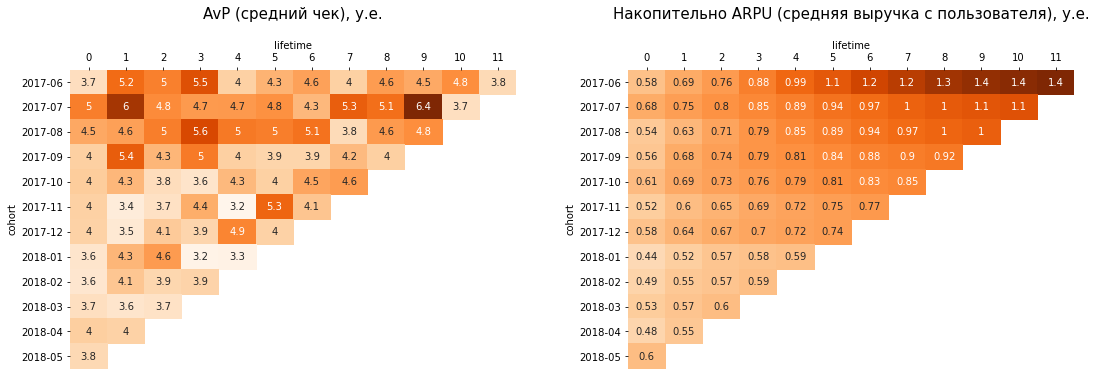

In [50]:
fig, ax_avp, ax_arpc = two_subplots(['AvP (средний чек), у.е.', 
                                     'Накопительно ARPU (средняя выручка с пользователя), у.е.'])
sns.heatmap(coh_unit()['avp'].unstack(), annot = True, cmap = 'Oranges', cbar = False, ax = ax_avp)
sns.heatmap(coh_unit()['arpu'].unstack().cumsum(axis = 1), annot = True, cmap = 'Oranges', 
            cbar = False, vmin = 0.2, ax = ax_arpc)
display(fig)
plt.close(fig)

Июнь, июль и август 2017 - самые прибыльные когорты для компании за год. Эти когорты выделяются и по показателю Retention, и по среднему чеку (AvP). Июнь 2017 - выдающаяся когорта ещё и по среднему числу покупок (APC). С каждой последующей когортой прибыль с одного пользователя (ARPU) всё хуже, особенно сильно ухудшение проявляется со второго месяца. ARPU это произведение следующих показателей: средний чек, среднее число покупок, валовая маржинальность и конверсия из посетителя в клиента. Из них мы видели только один, который из месяца в месяц изменялся в том же русле, что и ARPU на этом графике - это конверсия. Значит, между ними есть корреляция. Но ARPU - производная величина, а значит, она может быть вызвана, но сама ничего не вызывает. Тогда единственное объяснение - что падение ARPU вызвано падением Retention целевых клиентов. Целевые клиенты, напомню, это обобщение, под которым понимается определённая группа клиентов - это те, кто совершают покупки и пользуются сервисом больше двух месяцев, и остаются с компанией неопределённо долго. Мы также предложили для удобства считать, что в месяц они совершают не меньше 0.6 покупок (чтобы отделять от тех, кого спустя большие промежутки времени удаётся повторно привлечь с помощью вложений в каналы привлечения).

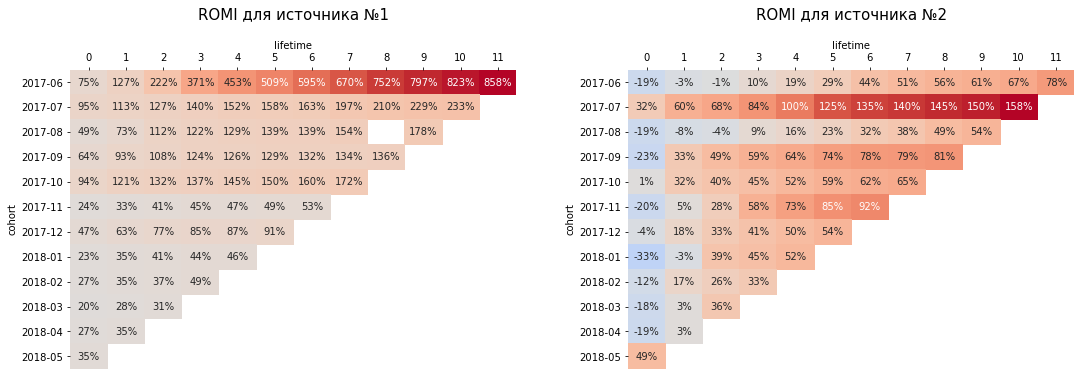

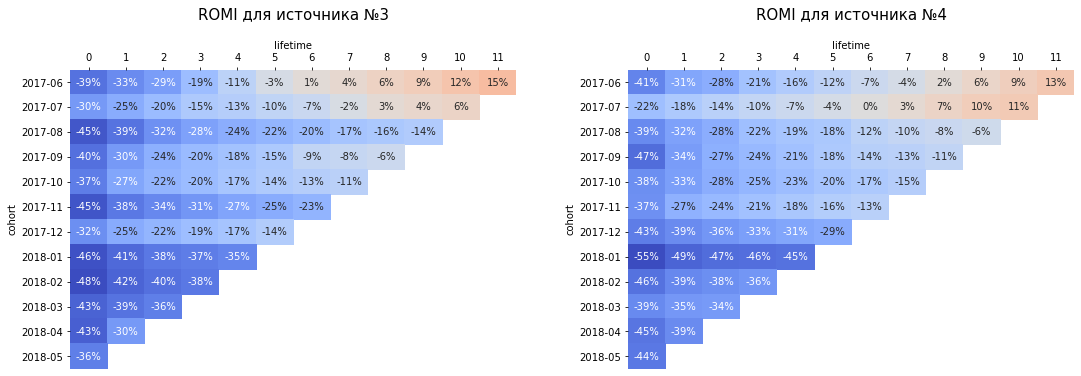

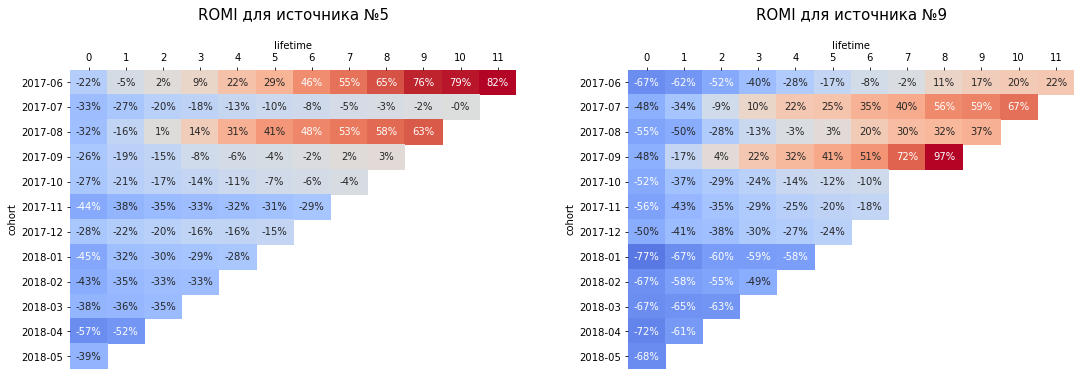

In [51]:
fig1, ax_source_1, ax_source_2 = two_subplots(['ROMI для источника №1', 'ROMI для источника №2'])
sns.heatmap(coh_unit(1)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_1)
sns.heatmap(coh_unit(2)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_2)

fig2, ax_source_3, ax_source_4 = two_subplots(['ROMI для источника №3', 'ROMI для источника №4'])
sns.heatmap(coh_unit(3)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_3)
sns.heatmap(coh_unit(4)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_4)

fig3, ax_source_5, ax_source_9 = two_subplots(['ROMI для источника №5', 'ROMI для источника №9'])
sns.heatmap(coh_unit(5)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_5)
sns.heatmap(coh_unit(9)['romi'].unstack(), annot = True, cmap = 'coolwarm', fmt = '.0%', center = 0,
            cbar = False, ax = ax_source_9)

for fig in [fig1, fig2, fig3]:
    display(fig)
    plt.close(fig)

Проверим, откуда пропуск в когорте '2017-08' из первого источника на 8 месяце lifetime - если это концептуальная ошибка в коде, то неверно посчитано не только значение пропущенной ячейки, но вообще всё. 

In [52]:
display(orders[ (orders.cohort == '2017-08') & (orders.lifetime == 8) & (orders.initial_source == 1) ])
4435931324057795549 in super_vip

,time_of_purchase,uid,revenue,initial_source,first_session_month,cohort,month,first_order_month,device,lifetime
6640,2018-04-03 13:00:00,4435931324057795549,3.30,1,2017-08-01,2017-08,2018-04-01,2017-08-01,desktop,8
6641,2018-04-08 12:47:00,4435931324057795549,7.82,1,2017-08-01,2017-08,2018-04-01,2017-08-01,desktop,8
6642,2018-04-16 10:49:00,4435931324057795549,1.22,1,2017-08-01,2017-08,2018-04-01,2017-08-01,desktop,8


True

Всё правильно. По запросу нашлись покупки лишь одного клиента, которого мы условились исключить из когортного анализа как клиента со слишком высоким средним чеком.

Посмотрим на тепловые карты. Вложения в первый источник окупаются на первом месяце, во второй - на третьем. Пятый источник был привлекательным до ноября 2017, но в последующих когортах что-то испортилось. Мы видели резкий рост MAU и рист числа постоянных клиентов с пиком в ноябре - возможно, в ноябре в отделе маркетинга воцарилось чувство эйфории, на фоне чего начали закупать некачественный трафик. Хотя, с другой стороны, маркетинговые инвестиции сократились только в январе.

По итогам года пользователи, привлечённые из пятого источника, окупили маркетинговые вложения в них (то, что это так, было посчитано в первом разделе проекта), но, если продолжить вкладывать в пятый источник в следующем году, то окупить средства, скорее всего, не получится. Девятый источник подобен пятому в том, что все когорты, начиная с ноября 2017, плохо стартовали. В противном случае можно было бы рассчитывать на возврат инвестиций в 5 и 9 источники за 8-9 месяцев.

Если бы Retention не падал так стремительно, можно было бы обнадёжить компанию - мол, независимо от источника вы с каждой когорты вы приобретаете небольшую, но постоянную группу клиентов, которая медленно, но верно окупает затраты на привлечение когорты. Можно было бы ожидать, что в таком случае со временем компания обзаведётся критической массой клиентов, уже окупивших свои когорты и приносящих прибыль. 

<a id='target99'></a>
## Резюме
[// вернуться к началу](#target100) 

- Взятый год принёс валовой убыток в размере 77 тысяч у.е. Компания заработала с одного пользователя 1.10 у.е., потратив на его привлечение 1.44 у.е. Конверсия в первую покупку высокая - 16%. Низкое среднее количество покупок - 1.38 и низкая конверсия в повторную покупку - 17%. 

- Метрики роста начали стремительно расти в сентябре, а после ноября начали постепенно падать. Заметна некоторая корреляций объёмов инвестиций с метриками роста (больше вложений - больше трафик, больше покупок, больше длительность), но за год совсем не было корреляции между метриками роста и коммерческими метриками - рост первых не обеспечил роста вторых.

- Не удалось найти закономерности, связывающие объём и время инвестиций с их эффективностью. Данных может быть недостаточно, но судя по тому, что есть, с объёмом и периодичностью инвестиций можно экспериментировать.

- Сессий с устройств desktop на протяжении всего года примерно в три раза больше, чем с touch (соотношение ощутимо не изменяется). У клиентов, пользующихся устройствами desktop, средняя сессия значимо дольше, а средняя выручка с них значимо выше. Разница выборочных средних - 1.5 у.е, а разница истинных средних при уровне значимости 0.05 будет не меньше 0.86 у.е.

- Подавляющее большинство клиентов "живёт" меньше месяца и ограничивается одной покупкой. Даже среди клиентов, совершивших две и более покупок, 78.3% пользуются сервисом нерегулярно, от случая к случаю. Больше половины первых покупок севершаются в срок менее двадцати минут. Больше 65% - в срок до двух часов. Конверсия во вторую покупку на данный момент является "узким" местом, то есть создаёт возможности для кратного роста. Представим, что конверсию во вторую покупку удалось поднять, благодаря чему среднее число покупок на клиента увеличилось с 1.38 до 2 (реалистичная задача - в некоторых когортах уже удавалось достичь этой цифры)...

In [53]:
calc_unit(visits, orders, costs, fix = {'APC': 2});

  UA = 228168
  C1 = 0.147
   B = 33517.0
 AvP = 4.875
 APC = 2
  AC = 325010.12
 CPA = 1.424
ARPC = 9.75
ARPU = 1.432
 CMU = 0.008
  CM = 1777.869
ROMI = 0.005


...и тогда за год, при всей убыточности инвестиций в третий и четвёртый источники (на которые приходилось более 60% всего маркетингового бюджета), вложения бы полностью окупились и принесли валовую прибыль.

- Сформулировали образ идеального "целевого" клиента. Целевые клиенты совершают покупки и пользуются сервисом больше двух месяцев, и остаются с компанией неопределённо долго. Для удобства было предложено считать, что в месяц они совершают не меньше 0.6 покупок (чтобы отделять от тех, кого с большими промежутками удаётся повторно привлечь за счёт вложений в маркетинг). За один день целевые клиенты заходят на сайт в среднем 1.5 раз, проводит на сайте в среднем 21 минуту в день (или 12 минут, если судить по медиане).

- Сервис сталкивается с новой проблемой - со временем становится всё больше клиентов, для которых сервис представляет ценность "на один раз". Когорты всё хуже окупают вложения. Следует разобраться в причинах - к примеру, некоторые действия в январе привели к стремительному снижению Retention среди клиентов, а в марте и мае - к небольшому повышению. Возможно, сайт становится скучным, и следует поработать над тем, чтобы сайт, помимо агрегатора билетов, был успешен ещё и как портал о культурной жизни. Вызывал привыкание как чтение газет. 

- Рекомендуется вкладывать в 1 и 2 источники. Первый источник окупается за первый месяц благодаря 30%-ой конверсии в первую покупку, а 2 источник - за три месяца благодаря высокому среднему чеку и высокому среднему числу покупок. Если получится понять, что случилось в ноябре 2017 с пользователями, привлечёнными из 5 и 9 источников, то в них тоже (но в 9 - с большим риском). Вложения в 3 и 4 источники не окупаются.

- Если компания планирует окупать вложения в течение года, то цена за посетителя не должна превышать его годового LTV. За пользователя из канала №2 можно заплатить не больше 2.66 у.е. Из канала №1 - не больше 3.28 у.е. Из канала №5 - не больше 1.06 у.е. Из канала №9 - не больше 0.89 у.е.